In [1]:
import Pkg

Pkg.add("StatsBase")
Pkg.add("Plots")
Pkg.add("GLMakie")
Pkg.add("Clustering")
Pkg.add("CairoMakie")


In [ ]:
using DataFrames
using CSV
using StatsBase
using GLMakie
using CairoMakie
using Clustering

using Printf

## Loading and Size

In [32]:
# Load the dataset
# Build the file path dynamically
file_path = joinpath(@__DIR__, "../dat/bottle.csv")
calcofi_data = CSV.read(file_path, DataFrame)

# Get the shape of the dataset
n_rows, n_cols = size(calcofi_data)
println("The dataset has $n_rows rows and $n_cols columns.")

The dataset has 864863 rows and 74 columns.


## Dtypes

In [33]:
# Get the data types of each column
println("\nColumn Data Types:")
for (col_name, col_type) in zip(names(calcofi_data), eltype.(eachcol(calcofi_data)))
    @printf("%-20s | %-13s\n", col_name, col_type)
end


Column Data Types:
Cst_Cnt              | Int64        
Btl_Cnt              | Int64        
Sta_ID               | String15     
Depth_ID             | String       
Depthm               | Int64        
T_degC               | Union{Missing, Float64}
Salnty               | Union{Missing, Float64}
O2ml_L               | Union{Missing, Float64}
STheta               | Union{Missing, Float64}
O2Sat                | Union{Missing, Float64}
Oxy_µmol/Kg          | Union{Missing, Float64}
BtlNum               | Union{Missing, Int64}
RecInd               | Int64        
T_prec               | Union{Missing, Int64}
T_qual               | Union{Missing, Int64}
S_prec               | Union{Missing, Int64}
S_qual               | Union{Missing, Int64}
P_qual               | Union{Missing, Int64}
O_qual               | Union{Missing, Int64}
SThtaq               | Union{Missing, Int64}
O2Satq               | Union{Missing, Int64}
ChlorA               | Union{Missing, Float64}
Chlqua               | U

## Missing Values

### Counting Missing Values

In [34]:
function count_missing(df::DataFrame)
    # Calculate the number of missing values for each column
    missing_values = map(col -> count(ismissing, col), eachcol(df))
    return missing_values
end

# Count the number of missing values per column
missing_values = count_missing(calcofi_data)


function data_missing_percentage(df::DataFrame)
    # Calculate the percentage of missing values for each column
    missing_values = map(col -> count(ismissing, col), eachcol(df))
    missing_percentages = missing_values ./ n_rows .* 100
    return missing_percentages
end

missing_percentages = data_missing_percentage(calcofi_data);

In [35]:
println("Column               | Missing Count | Missing Percentage")
counter = 0
for (col_name, missing_count, missing_pct) in zip(names(calcofi_data), missing_values, missing_percentages)
    @printf("%-20s | %-13d | %-10.2f%%\n", col_name, missing_count, missing_pct)
    counter += 1

    if counter == 10
        println("-" ^ 57)
    end
end

Column               | Missing Count | Missing Percentage
Cst_Cnt              | 0             | 0.00      %
Btl_Cnt              | 0             | 0.00      %
Sta_ID               | 0             | 0.00      %
Depth_ID             | 0             | 0.00      %
Depthm               | 0             | 0.00      %
T_degC               | 10963         | 1.27      %
Salnty               | 47354         | 5.48      %
O2ml_L               | 168662        | 19.50     %
STheta               | 52689         | 6.09      %
O2Sat                | 203589        | 23.54     %
---------------------------------------------------------
Oxy_µmol/Kg          | 203595        | 23.54     %
BtlNum               | 746196        | 86.28     %
RecInd               | 0             | 0.00      %
T_prec               | 10963         | 1.27      %
T_qual               | 841736        | 97.33     %
S_prec               | 47354         | 5.48      %
S_qual               | 789949        | 91.34     %
P_qual           

## Data Cleaning

### Deleting Columns by Missing Percentage Threshold

In [36]:
function delete_columns(df::DataFrame, threshold::Float64)
    # Get missing percentages
    missing_percentages = data_missing_percentage(df)

    # Identify columns to drop based on missing percentage threshold
    cols_to_drop = names(df)[missing_percentages .> threshold]

    # Drop the identified columns 
    cleaned_data = select(df, Not(cols_to_drop))
    return cleaned_data
end;

In [37]:
# Threshold for missing values
threshold = 10.0

# Identify columns to drop based on missing percentage threshold
cols_to_drop = names(calcofi_data)[missing_percentages .> threshold]
n_cols_to_drop = length(cols_to_drop)
println("\nColumns dropped due to missing value threshold (total: $n_cols_to_drop): ", cols_to_drop)


Columns dropped due to missing value threshold (total: 50): ["O2ml_L", "O2Sat", "Oxy_µmol/Kg", "BtlNum", "T_qual", "S_qual", "P_qual", "O_qual", "SThtaq", "O2Satq", "ChlorA", "Chlqua", "Phaeop", "Phaqua", "PO4uM", "PO4q", "SiO3uM", "SiO3qu", "NO2uM", "NO2q", "NO3uM", "NO3q", "NH3uM", "C14As1", "C14A1p", "C14As2", "C14A2p", "DarkAs", "DarkAp", "MeanAs", "MeanAp", "IncTim", "LightP", "R_O2", "R_O2Sat", "R_SIO3", "R_PO4", "R_NO3", "R_NO2", "R_NH4", "R_CHLA", "R_PHAEO", "R_SAMP", "DIC1", "DIC2", "TA1", "TA2", "pH2", "pH1", "DIC Quality Comment"]


In [38]:
# Remove the columns with over 10% missing values
cleaned_data = delete_columns(calcofi_data, threshold)
println(size(cleaned_data))

(864863, 24)


## Correlation

In [39]:
function calculate_correlation(df::DataFrame)
    num_cols = ncol(df)
    matrix = zeros(Float64, num_cols, num_cols)

    for (i, target_col) in enumerate(names(df))
        for (j, col) in enumerate(names(df))
            indices = findall(row -> !ismissing(row[target_col]) && !ismissing(row[col]), eachrow(df))
            if length(indices) > 1  # Ensure enough valid rows for correlation
                temp_df = df[indices, :]
                matrix[i, j] = cor(temp_df[:, target_col], temp_df[:, col])
            else
                matrix[i, j] = NaN  # Not enough data for correlation
            end
        end
    end

    return matrix
end;

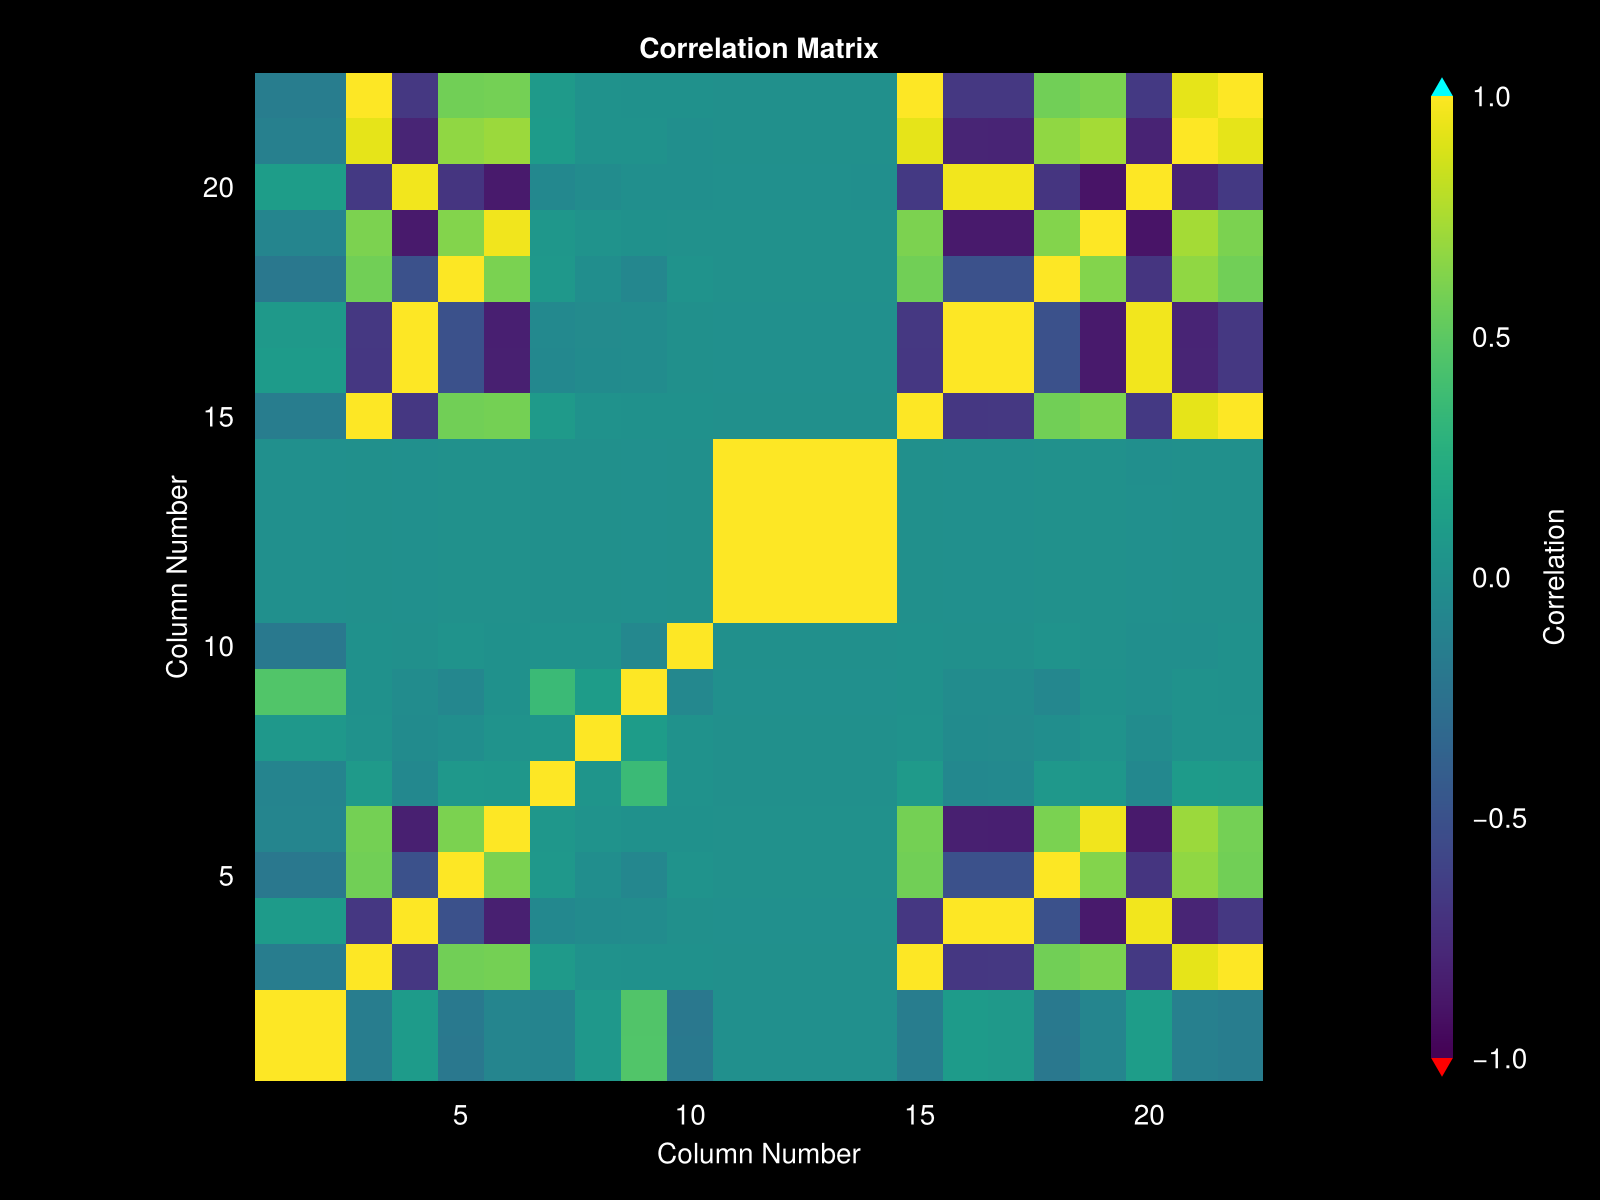

In [40]:
# Drop non numeric columns 
columns_to_drop = [:Sta_ID, :Depth_ID]
cleaned_numeric_data = select(cleaned_data, Not(columns_to_drop))

# Calculate Correlation Matrix
correlation_matrix = calculate_correlation(cleaned_numeric_data)

function display_correlation(correlation_matrix::Matrix{Float64})
    fig = Figure(size=(800,600), backgroundcolor = :black)  # Create a figure with specified resolution
    ax = Axis(fig[1, 1],
        title = "Correlation Matrix",
        xlabel = "Column Number",
        ylabel = "Column Number",
        aspect = 1,
        titlecolor = :white,  
        xlabelcolor = :white, 
        ylabelcolor = :white, 
        xticklabelcolor = :white, 
        yticklabelcolor = :white  
    )

    # Add the heatmap
    heatmap!(
        ax,
        correlation_matrix;
        colormap = :viridis,  
        colorrange = (-1, 1),  # Correlation values range from -1 to 1
    )

    # Add a colorbar
    Colorbar(fig[1, 2], limits = (-1, 1), colormap = :viridis, highclip = :cyan, lowclip = :red, label = "Correlation", labelcolor = :white, ticklabelcolor = :white)
    
    # Return figure ready to display
    return fig
    
end

fig = display_correlation(correlation_matrix)
display(fig);  # Display the figure



## Outlier Handling

In [41]:
function remove_outliers_IQR(df::DataFrame)
    outlier_indices = Set{Int}()  # Set to store indices of rows to remove

    #Calculate IQR and bounds for each numeric column
    for col in names(df)
        if eltype(df[!, col]) <: Real  # Check if column is numeric
            Q1 = quantile(skipmissing(df[!, col]), 0.25)
            Q3 = quantile(skipmissing(df[!, col]), 0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outlier indices for this column
            for (i, value) in enumerate(df[!, col])
                if !ismissing(value) && (value < lower_bound || value > upper_bound)
                    push!(outlier_indices, i)
                end
            end
        end
    end

    # Remove rows with indices in the outlier set
    cleaned_df = df[setdiff(1:nrow(df), collect(outlier_indices)), :]
    return cleaned_df
end;

In [42]:
cleaned_data = remove_outliers_IQR(cleaned_numeric_data)
size(cleaned_data)

(810081, 22)

## Handling Missing Values

In [43]:
# Function to delete rows with null values for a specific column
function delete_null_by_row(df::DataFrame, col::String)
    if col in names(df)
        df = filter(row -> !ismissing(row[col]), df)
    else
        println("Column $col does not exist in the dataset.")
    end
    return df
end

column_to_clean = "T_degC" 

original_missing_vals = count(ismissing, cleaned_numeric_data[!, column_to_clean ])
println("Original missing values: $original_missing_vals")

cleaned_data = delete_null_by_row(cleaned_numeric_data, column_to_clean)

original_row_count = nrow(cleaned_numeric_data)
clean_row_count = nrow(cleaned_data)
println("Original rows: $original_row_count\nClean rows: $clean_row_count")

Original missing values: 10963
Original rows: 864863
Clean rows: 853900


## Handling Irrelevant Data

In [44]:
function delete_columns_by_correlation(df::DataFrame, target_col::String, threshold::Float64)
    # Calculate correlations with the target column
    correlations = Dict{String, Float64}()
    for col in names(df)
        if col != target_col  # Skip the target column itself
            indices = findall(row -> !ismissing(row[target_col]) && !ismissing(row[col]), eachrow(df))
            if length(indices) > 1  # Ensure enough valid rows for correlation
                temp_df = df[indices, :]
                correlations[col] = cor(temp_df[:, target_col], temp_df[:,col])
            end
        end
    end

    # Filter columns based on correlation threshold
    high_corr_cols = filter(col -> abs(correlations[col]) ≥ threshold, keys(correlations))
    high_corr_cols = [target_col; high_corr_cols...]  # Include the target column in the result

    # Return the filtered DataFrame
    return select(df, high_corr_cols)

end


delete_columns_by_correlation (generic function with 1 method)

In [45]:
threshold = 0.5
col="T_degC"

filtered_df = delete_columns_by_correlation(cleaned_numeric_data, col, threshold)
println(size(filtered_df))

println(first(filtered_df, 5))

(864863, 12)
5×12 DataFrame
 Row │ T_degC    R_SVA     R_SALINITY  STheta    R_TEMP    R_Depth  Depthm  R_DYNHT   R_PRES  Salnty    R_POTEMP  R_SIGMA  
     │ Float64?  Float64?  Float64?    Float64?  Float64?  Float64  Int64   Float64?  Int64   Float64?  Float64?  Float64? 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │    10.5      233.0      33.44     25.649     10.5       0.0       0      0.0        0    33.44      10.5      25.64
   2 │    10.46     232.5      33.44     25.656     10.46      8.0       8      0.01       8    33.44      10.46     25.65
   3 │    10.46     232.8      33.437    25.654     10.46     10.0      10      0.02      10    33.437     10.46     25.65
   4 │    10.45     234.1      33.42     25.643     10.45     19.0      19      0.04      19    33.42      10.45     25.64
   5 │    10.45     234.0      33.421    25.643     10.45     20.0      20      0.04      20    33.421     1

## Describe Function


In [46]:
describe(calcofi_data)

74×7 DataFrame
 Row │ variable             mean      min                                media ⋯
     │ Symbol               Union…    Any                                Union ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Cst_Cnt              17138.8   1                                  16848 ⋯
   2 │ Btl_Cnt              432432.0  1                                  43243
   3 │ Sta_ID                         001.0 168.0                             
   4 │ Depth_ID                       19-4903CR-HY-060-0930-05400560-0…       
   5 │ Depthm               226.832   0                                  125.0 ⋯
   6 │ T_degC               10.7997   1.44                               10.06
   7 │ Salnty               33.8404   28.431                             33.86
   8 │ O2ml_L               3.39247   -0.01                              3.44
  ⋮  │          ⋮              ⋮                      ⋮                     ⋮  ⋱
  68 │ DIC1                 2153.24   1948.85                            2170. ⋯
  69 │ DIC2                 2168.15   1969.44                            2265.
  70 │ TA1                  2256.06   2181.57                            2244.
  71 │ TA2                  2278.86   2198.15                            2247.
  72 │ pH2                  7.94857   7.9231                             7.946 ⋯
  73 │ pH1                  7.91098   7.6183                             7.928
  74 │ DIC Quality Comment            Bottle tripped at correct depth         
                                                   4 columns and 59 rows omitted

In [47]:
describe(cleaned_numeric_data)

22×7 DataFrame
 Row │ variable    mean           min     median      max         nmissing  el ⋯
     │ Symbol      Float64        Real    Float64     Real        Int64     Ty ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Cst_Cnt      17138.8        1       16848.0     34404             0  In ⋯
   2 │ Btl_Cnt     432432.0        1      432432.0    864863             0  In
   3 │ Depthm         226.832      0         125.0      5351             0  In
   4 │ T_degC          10.7997     1.44       10.06       31.14      10963  Un
   5 │ Salnty          33.8404    28.431      33.863      37.034     47354  Un ⋯
   6 │ STheta          25.8194    20.934      25.996     250.784     52689  Un
   7 │ RecInd           4.70027    3           3.0         7             0  In
   8 │ T_prec           2.01715    1           2.0         3         10963  Un
  ⋮  │     ⋮             ⋮          ⋮         ⋮           ⋮          ⋮         ⋱
  16 │ R_TEMP          10.7997     1.44       10.06       31.14      10963  Un ⋯
  17 │ R_POTEMP        10.8423     0.0        10.1        31.14      46047  Un
  18 │ R_SALINITY      33.8403     4.57       33.863      37.034     47354  Un
  19 │ R_SIGMA         25.811     20.934      25.99      250.784     52856  Un
  20 │ R_SVA          220.939      0.4       203.2       683.4       52771  Un ⋯
  21 │ R_DYNHT          0.431763   0.0         0.34        3.88      46657  Un
  22 │ R_PRES         228.396      0         126.0      5458             0  In
                                                     1 column and 7 rows omitted